In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from report_config import ReportConfig

In [2]:
def get_bad_rating_companies(df):
    negative_greater_than_positive = df[df["2negative"] > df["1positive"]]

    negative_greater_than_positive = negative_greater_than_positive.sort_values(
        by="2negative", ascending=False
    ).reset_index()

    return list(negative_greater_than_positive["company"].values)


def get_good_rating_companies(df):
    positive_greater_than_negative = df[df["1positive"] > df["2negative"]]

    positive_greater_than_negative = positive_greater_than_negative.sort_values(
        by="1positive", ascending=False
    ).reset_index()

    return list(positive_greater_than_negative["company"].values)


def get_neutral_rating_companies(df):
    positive_equal_to_negative = df[df["1positive"] == df["2negative"]]

    return list(positive_equal_to_negative["company"].values)

In [3]:
reviews_df = pd.read_csv("./glassdoor_reviews_predicted.csv")

In [4]:
mean_reviews_count = len(reviews_df) / len(reviews_df["company"].unique())
print(f"Média de avaliações por Empresa: {int(mean_reviews_count)}")

Média de avaliações por Empresa: 115


In [5]:
review_counts_df = reviews_df.groupby("company")["review_id"].count()
sorted_counts = review_counts_df.sort_values()
median = sorted_counts.median()
print(f"Mediana de avaliações por Empresa: {int(median)}")

Mediana de avaliações por Empresa: 42


In [6]:
MIN_REVIEWS = int(median / 2)

Quantiadde 


In [7]:
reviews_df["sentiment"] = reviews_df["sentiment"].apply(lambda x: 2 if x == -1 else x)

In [8]:
reviews_df["predicted_sentiment_label"] = reviews_df["predicted_sentiment"].map(
    ReportConfig.SENTIMENT_DICT
)

In [9]:
conditions = [
    (reviews_df["predicted_sentiment"] == 0),
    (reviews_df["predicted_sentiment"] == 1),
    (reviews_df["predicted_sentiment"] == 2),
]

values = [3, 1, 2]

reviews_df["predicted_sentiment_plot"] = np.select(conditions, values)

In [10]:
reviews_df.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated,predicted_sentiment,predicted_sentiment_label,predicted_sentiment_plot
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",2023-12-15,5.0,1,0,1,Positivo,1
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,2023-12-15,5.0,0,1,0,Neutro,3


In [11]:
reviews_count_df = reviews_df.groupby(["company"])["review_text"].count()

In [12]:
reviews_count_df = reviews_count_df.reset_index()
reviews_count_df.columns = [
    "company",
    "reviews_count",
]

In [13]:
reviews_df = pd.merge(
    left=reviews_df,
    right=reviews_count_df,
    on="company",
    how="left",
)

In [14]:
predicted_sentiment_plot_by_company_df = (
    reviews_df.groupby(["company", "predicted_sentiment_plot"])["review_text"]
    .count()
    .unstack(fill_value=0)
)

In [15]:
predicted_sentiment_plot_by_company_df = (
    predicted_sentiment_plot_by_company_df.reset_index()
)

In [16]:
predicted_sentiment_plot_by_company_df.columns = [
    "company",
    "1positive",
    "2negative",
    "3neutral",
]

In [17]:
predicted_sentiment_plot_by_company_df["sentiment_diff"] = (
    predicted_sentiment_plot_by_company_df["1positive"]
    - predicted_sentiment_plot_by_company_df["2negative"]
)

In [18]:
predicted_sentiment_plot_by_company_df.head()

,company,1positive,2negative,3neutral,sentiment_diff
0,Abaco Tecnologia de Informação Ltda,50,50,10,0
1,Agenda Assessoria,46,40,10,6
2,Amaggi,438,349,69,89
3,Cigam Software Corporativo,176,139,39,37
4,Coplan Consultoria e Planejamento,15,14,3,1


In [19]:
predicted_sentiment_plot_by_company_df = (
    predicted_sentiment_plot_by_company_df.sort_values(
        by="sentiment_diff", ascending=False
    ).reset_index()
)

In [20]:
predicted_sentiment_plot_by_company_df = predicted_sentiment_plot_by_company_df.drop(
    labels="index", axis=1
)

In [21]:
bad_rating_companies = get_bad_rating_companies(predicted_sentiment_plot_by_company_df)

In [22]:
good_rating_companies = get_good_rating_companies(
    predicted_sentiment_plot_by_company_df
)

In [23]:
neutral_rating_companies = get_neutral_rating_companies(
    predicted_sentiment_plot_by_company_df
)

In [24]:
reviews_30_plus_df = pd.merge(
    left=reviews_df,
    right=predicted_sentiment_plot_by_company_df,
    on="company",
    how="left",
)

In [25]:
reviews_30_plus_df = reviews_30_plus_df.sort_values(
    by="sentiment_diff", ascending=False
).reset_index()

In [26]:
reviews_30_plus_df = reviews_30_plus_df[
    reviews_30_plus_df["reviews_count"] >= MIN_REVIEWS
]

In [27]:
conditions = [
    (reviews_30_plus_df["predicted_sentiment_plot"] == 1),  # Positive
    (reviews_30_plus_df["predicted_sentiment_plot"] == 2),  # Negative
    (reviews_30_plus_df["predicted_sentiment_plot"] == 3),  # Neutral
]

In [28]:
values = [
    reviews_30_plus_df["1positive"],
    reviews_30_plus_df["2negative"],
    reviews_30_plus_df["3neutral"],
]

In [29]:
reviews_30_plus_df["sentiment_count"] = np.select(conditions, values, default=0)

In [30]:
top_good_bad_companies_by_sentiment_diff = reviews_30_plus_df[
    (
        reviews_30_plus_df["company"].isin(good_rating_companies[:5])
        | reviews_30_plus_df["company"].isin(bad_rating_companies[:5])
    )
]

In [31]:
top_positive_companies_df = top_good_bad_companies_by_sentiment_diff[
    top_good_bad_companies_by_sentiment_diff["sentiment_diff"] > 0
]

In [32]:
top_positive_companies_df = top_positive_companies_df.sort_values(
    # by="reviews_count", ascending=False
    by=["sentiment_diff", "reviews_count"],
    ascending=False,
).reset_index()

In [33]:
top_negative_companies_df = top_good_bad_companies_by_sentiment_diff[
    top_good_bad_companies_by_sentiment_diff["sentiment_diff"] < 0
]

In [34]:
top_negative_companies_df = top_negative_companies_df.sort_values(
    # by="reviews_count", ascending=False
    by=["sentiment_diff", "reviews_count"],
    ascending=True,
).reset_index()

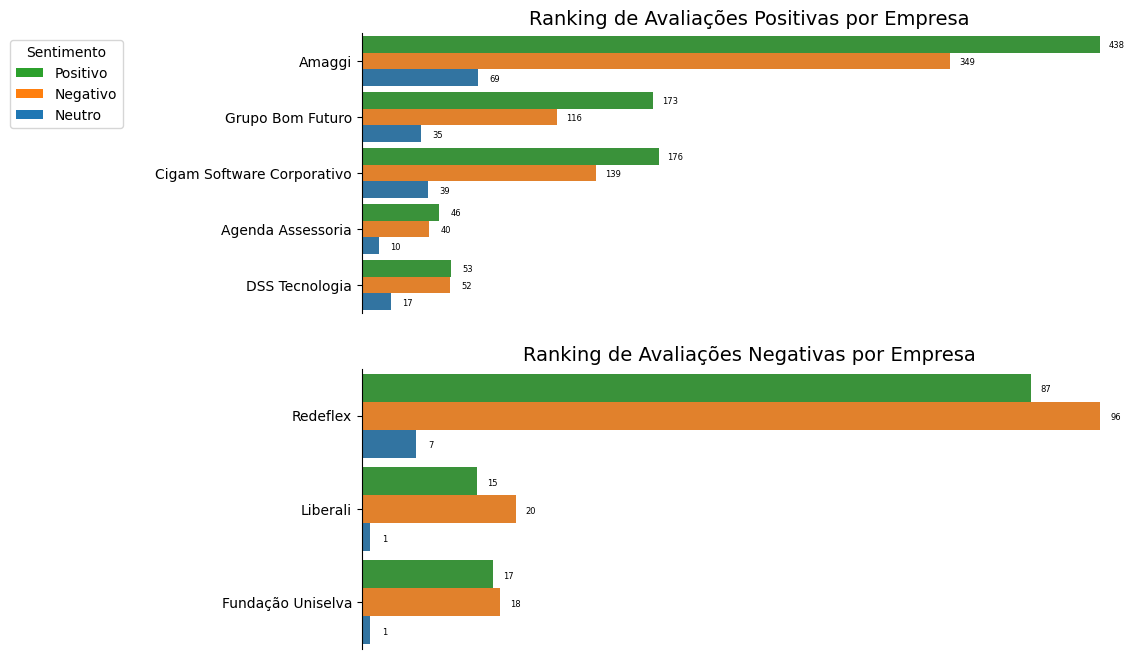

In [35]:
fig, ax = plt.subplots(2, figsize=(10, 8))

# Barplots
sns.barplot(
    data=top_positive_companies_df,
    x="sentiment_count",
    y="company",
    hue="predicted_sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax[0],
    width=0.9,
    orient="h",
)

sns.barplot(
    data=top_negative_companies_df,
    x="sentiment_count",
    y="company",
    hue="predicted_sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax[1],
    width=0.9,
    orient="h",
)

# Annotates
for p in ax[0].patches:
    ax[0].annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 10, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

for p in ax[1].patches:
    ax[1].annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 2, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

# Axes config
ax[0].set_xlabel("")
ax[1].set_xlabel("")

ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_ylabel("")
ax[1].set_ylabel("")

ax[0].set_title(
    "Ranking de Avaliações Positivas por Empresa",
    fontdict={
        # "weight": "bold",
        "size": ReportConfig.CHART_TITLE_FONT_SIZE,
    },
    loc="center",
)

ax[1].set_title(
    "Ranking de Avaliações Negativas por Empresa",
    fontdict={
        # "weight": "bold",
        "size": ReportConfig.CHART_TITLE_FONT_SIZE,
    },
    loc="center",
)

ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

positive_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR)
negative_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax[0].legend(
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=["Positivo", "Negativo", "Neutro"],
    title="Sentimento",
    bbox_to_anchor=(-0.3, 1),
    # loc="upper center"
)

ax[1].get_legend().remove()

plt.show()

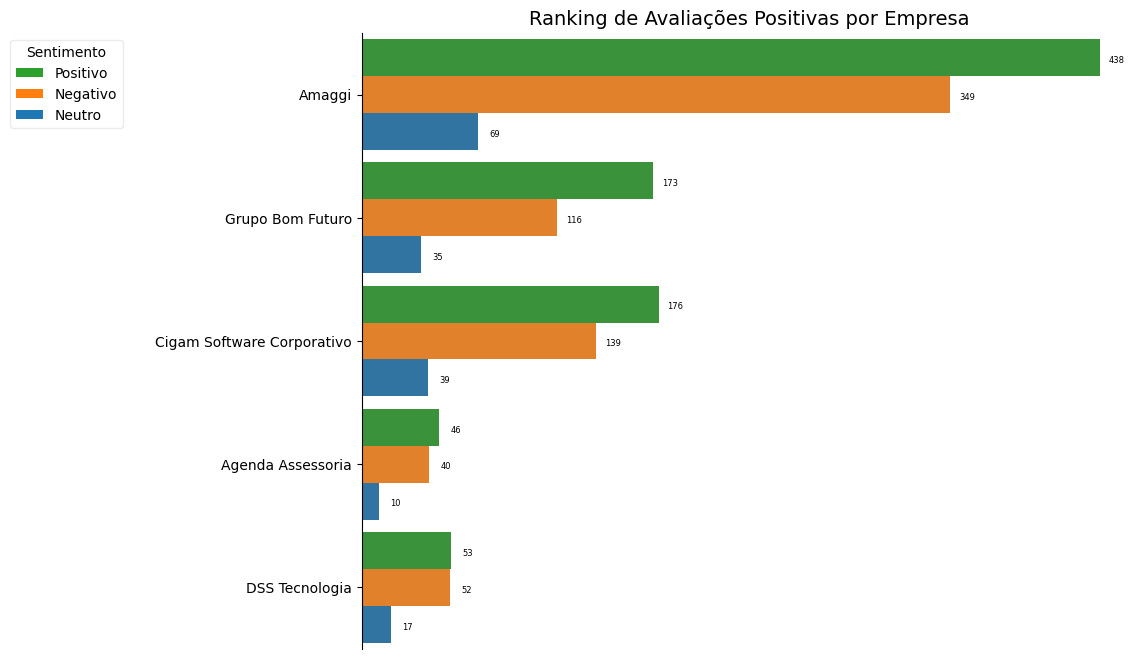

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 8))

# Barplots
sns.barplot(
    data=top_positive_companies_df,
    x="sentiment_count",
    y="company",
    hue="predicted_sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax,
    width=0.9,
    orient="h",
)

# Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 10, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

# Axes config
ax.set_xlabel("")

ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Ranking de Avaliações Positivas por Empresa",
    fontdict={
        #  "weight": "bold",
        "size": ReportConfig.CHART_TITLE_FONT_SIZE,
    },
    loc="center",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)


positive_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR)
negative_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax.legend(
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=["Positivo", "Negativo", "Neutro"],
    title="Sentimento",
    bbox_to_anchor=(-0.3, 1),
    # loc="upper left",
    edgecolor=".9",
    ncols=1,
)

# ax.legend.get_frame().set_facecolor("none")

plt.show()

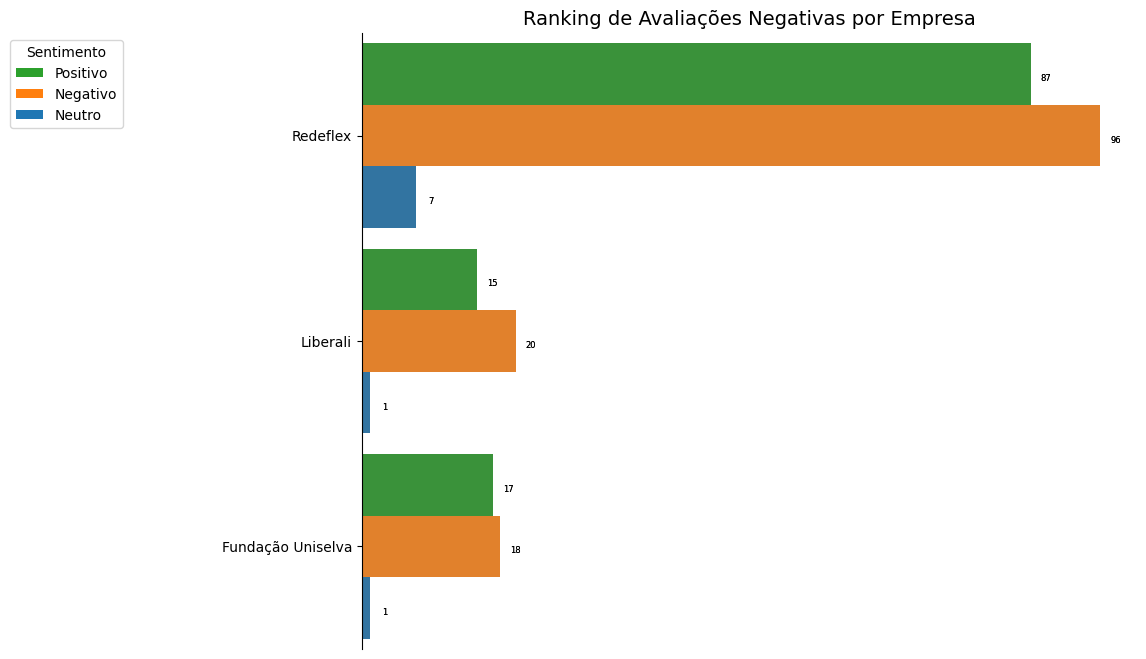

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 8))

# Barplots
sns.barplot(
    data=top_negative_companies_df,
    x="sentiment_count",
    y="company",
    hue="predicted_sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax,
    width=0.9,
    orient="h",
)

# Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 2, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width() + 2, (p.get_y() + p.get_height() / 2) + 0.02),
        ha="center",
        va="center",
        fontsize=6,
        color="black",
        xytext=(0, 0),
        textcoords="offset points",
    )

# Axes config
ax.set_xlabel("")

ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Ranking de Avaliações Negativas por Empresa",
    fontdict={
        # "weight": "bold",
        "size": ReportConfig.CHART_TITLE_FONT_SIZE,
    },
    loc="center",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)


positive_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR)
negative_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax.legend(
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=["Positivo", "Negativo", "Neutro"],
    title="Sentimento",
    bbox_to_anchor=(-0.3, 1),
    # loc="upper center"
)

plt.show()